In [43]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

In [44]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
#X_train = np.load("x_smote.npy")
#y_train = np.load("y_smote.npy")
x_project = np.load("Xtest_Classification1.npy")
X_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

print(X_train.shape,y_train.shape,x_project.shape,X_test.shape,y_test.shape)



(6449, 28, 28, 3) (6449, 2) (1764, 2352) (1251, 28, 28, 3) (1251, 2)


In [45]:
X_train = np.pad(X_train, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant', constant_values=0)
X_test = np.pad(X_test, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant', constant_values=0)

Epoch 1/10
101/101 [==============================] - 24s 228ms/step - loss: 0.6129 - accuracy: 0.6502 - val_loss: 0.4130 - val_accuracy: 0.8713
Epoch 2/10
101/101 [==============================] - 24s 241ms/step - loss: 0.5318 - accuracy: 0.7310 - val_loss: 0.4245 - val_accuracy: 0.8369
Epoch 3/10
101/101 [==============================] - 27s 264ms/step - loss: 0.4982 - accuracy: 0.7552 - val_loss: 0.3700 - val_accuracy: 0.8449
Epoch 4/10
101/101 [==============================] - 27s 271ms/step - loss: 0.4839 - accuracy: 0.7604 - val_loss: 0.3826 - val_accuracy: 0.8329
Epoch 5/10
101/101 [==============================] - 27s 267ms/step - loss: 0.4735 - accuracy: 0.7651 - val_loss: 0.3732 - val_accuracy: 0.8321
Epoch 6/10
101/101 [==============================] - 27s 272ms/step - loss: 0.4669 - accuracy: 0.7714 - val_loss: 0.3869 - val_accuracy: 0.8289
Epoch 7/10
101/101 [==============================] - 27s 265ms/step - loss: 0.4596 - accuracy: 0.7753 - val_loss: 0.3860 - val_ac

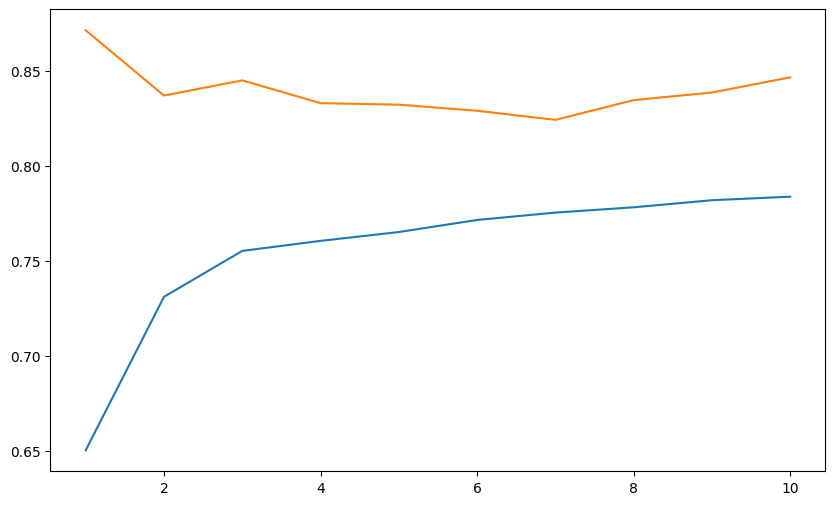

In [46]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose = 3, restore_best_weights=True)

class_weight = {0: 0.5, 1: 1.}

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test) ,callbacks=[early_stopping], class_weight=class_weight)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')



In [47]:
y_predi = model.predict(X_test)

for i in y_predi:
    if i[0]>i[1]:
        i[0]=1
        i[1]=0
    else:
        i[0]=0
        i[1]=1
        
print(y_predi[:,0])

balanced_accuracy = balanced_accuracy_score(y_test[:,1], y_predi[:,1])
print("Balanced Accuracy Score:", balanced_accuracy)



40/40 [==============================] - 6s 146ms/step
[1. 1. 1. ... 0. 1. 1.]
Balanced Accuracy Score: 0.7071326691475329


In [48]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

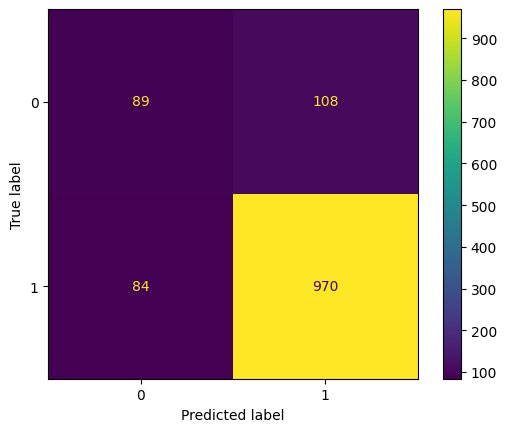

In [49]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_predi[:,0],y_test[:,0])
cm_display=ConfusionMatrixDisplay(cm).plot()